In [2]:
import numpy as np
import math
import os
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.utils import summarize_circuits
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import GroverOperator

In [4]:
results_dir = os.path.join("..", "paper", "results")
os.makedirs(results_dir, exist_ok=True)

Design constraints
- Each element $x \in \{0, 1\}$
- $n \in \mathbb{N}$ and $\sqrt{n} \in \mathbb{N}$

In [ ]:
# https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [ ]:
def check_square_matrix(a):
    assert len(a.shape) == 2, "a is not a 2-d matrix"
    m, n = a.shape
    assert m == n, "a is not a square matrix"

In [ ]:
def qvmp(a, b, c):
    assert a.shape == b.shape and b.shape == c.shape, "a, b, c do not have the same dimensions"
    
    check_square_matrix(a)
    check_square_matrix(b)
    check_square_matrix(c)
    
    n = a.shape[0]
    assert math.sqrt(n).is_integer(), f"n = {n} is not a square number"
    n_s = int(math.sqrt(n))

    bis = blockshaped(b, n, n_s)
    cis = blockshaped(c, n, n_s)
    blocks = zip(bis, cis)

    results = []
    for (bi, ci) in blocks:
        circ = vmp_circ(a, bi, ci)
#         circ.run()
#         results.append(circ.measure())

    return all(results)

In [ ]:
np.random.seed(0)
a = np.random.randint(0, 2, (4,4))
b = np.random.randint(0, 2, (4,4))
c = np.random.randint(0, 2, (4,4))

qvmp(a, b, c)

## Utilities

In [12]:
def encode_array(qc, a_reg, a):
    a_flat = a.reshape(-1)
    it = np.nditer(a_flat, flags=['f_index'])
    for x in it:
        if x != 0:
            qc.x(a_reg[it.index])

In [13]:
def sim_aer(qc):
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_sim)
    qobj = assemble(transpiled_qc)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts()
    plot_histogram(counts)

## Matrix Row Indexing

In [14]:
def matrix_row_indexer(num_rows, num_columns):
    num_matrix_elements = num_rows * num_columns
    num_idx_bits = math.ceil(math.log2(num_rows))
    
    matrix_reg = QuantumRegister(num_matrix_elements, name="a")
    idx_reg = QuantumRegister(num_idx_bits, name="idx")
    data_reg = QuantumRegister(num_columns, name="data")
    
    qc = QuantumCircuit(matrix_reg, idx_reg, data_reg)
    
    for i in range(num_rows):
        # set up idx
        idx_bit_string = format(i, f'0{num_idx_bits}b')[::-1]
        for j, c in enumerate(idx_bit_string):
            if c == '0':
                qc.x(idx_reg[j])

        # do the index
        idx_qubits = [qubit for qubit in idx_reg]
        for j in range(i*num_columns, (i+1)*num_columns):
            qc.mct([matrix_reg[j]] + idx_qubits, data_reg[j%num_columns])

        # reset idx
        for j, c in enumerate(idx_bit_string):
            if c == '0':
                qc.x(idx_reg[j])
    
    return qc

In [88]:
a = np.array([[0, 1, 0, 1],
              [1, 1, 1, 0],
              [1, 0, 0, 1],
              [1, 0, 1, 0]])
idx = 3

num_matrix_elements = a.size
dim = a.shape[0]
num_idx_bits = int(math.log2(dim))

matrix_reg = QuantumRegister(num_matrix_elements, name="a")
idx_reg = QuantumRegister(num_idx_bits, name="idx")
data_reg = QuantumRegister(dim, name="data")
data_creg = ClassicalRegister(dim, name="cdata")

qc = QuantumCircuit(matrix_reg, idx_reg, data_reg, data_creg)
qc.h(idx_reg)

# encode matrix
a_flat = a.reshape(-1)
it = np.nditer(a_flat, flags=['f_index'])
for x in it:
    if x != 0:
        qc.x(matrix_reg[it.index])
    
# encode idx
# idx_bit_string = format(idx, f'0{num_idx_bits}b')[::-1]
# for i, c in enumerate(idx_bit_string):
#     if c != '0':
#         qc.x(idx_reg[i])

m_i = matrix_row_indexer(*a.shape).to_gate()
m_i.name = "Matrix Row Indexer"
qc.append(m_i, [*matrix_reg, *idx_reg, *data_reg])

# DEBUG test the matrix indexing circuit
qc.measure(data_reg[::-1], data_creg)
qc.draw()

┌──────────────────────┐            
    a_0: ─────┤0                     ├────────────
         ┌───┐│                      │            
    a_1: ┤ X ├┤1                     ├────────────
         └───┘│                      │            
    a_2: ─────┤2                     ├────────────
         ┌───┐│                      │            
    a_3: ┤ X ├┤3                     ├────────────
         ├───┤│                      │            
    a_4: ┤ X ├┤4                     ├────────────
         ├───┤│                      │            
    a_5: ┤ X ├┤5                     ├────────────
         ├───┤│                      │            
    a_6: ┤ X ├┤6                     ├────────────
         └───┘│                      │            
    a_7: ─────┤7                     ├────────────
         ┌───┐│                      │            
    a_8: ┤ X ├┤8                     ├────────────
         └───┘│                      │            
    a_9: ─────┤9                     ├────────────
              │                      │            
   a_10: ─────┤10                    ├────────────
         ┌───┐│   Matrix Row Indexer │            
   a_11: ┤ X ├┤11                    ├────────────
         ├───┤│                      │            
   a_12: ┤ X ├┤12                    ├────────────
         └───┘│                      │            
   a_13: ─────┤13                    ├────────────
         ┌───┐│                      │            
   a_14: ┤ X ├┤14                    ├────────────
         └───┘│                      │            
   a_15: ─────┤15                    ├────────────
         ┌───┐│                      │            
  idx_0: ┤ H ├┤16                    ├────────────
         ├───┤│                      │            
  idx_1: ┤ H ├┤17                    ├────────────
         └───┘│                      │         ┌─┐
 data_0: ─────┤18                    ├─────────┤M├
              │                      │      ┌─┐└╥┘
 data_1: ─────┤19                    ├──────┤M├─╫─
              │                      │   ┌─┐└╥┘ ║ 
 data_2: ─────┤20                    ├───┤M├─╫──╫─
              │                      │┌─┐└╥┘ ║  ║ 
 data_3: ─────┤21                    ├┤M├─╫──╫──╫─
              └──────────────────────┘└╥┘ ║  ║  ║ 
cdata: 4/══════════════════════════════╩══╩══╩══╩═
                                       0  1  2  3

In [89]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts).savefig(f"{results_dir}/indexer_superposition.png")

## Inner Product

In [15]:
def inner_product(vec_size):
    a_reg = QuantumRegister(vec_size, name="x")
    b_reg = QuantumRegister(vec_size, name="y")
    i_reg = QuantumRegister(vec_size, name="i")
    out_reg = QuantumRegister(1, name="out")
    
    qc = QuantumCircuit(a_reg, b_reg, i_reg, out_reg)
    
    # out-of-place multiplication (logical AND)
    for i in range(vec_size):
        qc.ccx(a_reg[i], b_reg[i], i_reg[i])

    # out-of-place addition (logical OR)
    for i in range(vec_size):
        qc.x(i_reg[i])

    qc.mct(i_reg, out_reg)

    for i in range(vec_size):
        qc.x(i_reg[i])

    qc.x(out_reg)
    
    return qc

In [84]:
# x = np.array([1, 1, 1, 1])
# y = np.array([1, 0, 1, 0])
# dim = x.size

x = np.array([0, 1, 0, 1])
y = np.array([1, 0, 1, 0])
dim = x.size

x_reg = QuantumRegister(dim, name="x")
y_reg = QuantumRegister(dim, name="y")
i_reg = QuantumRegister(dim, name="i")
out_reg = QuantumRegister(1, name="out")
out_creg = ClassicalRegister(1, name="cout")

qc = QuantumCircuit(x_reg, y_reg, i_reg, out_reg, out_creg)

# encode the rows
it = np.nditer(x, flags=['f_index'])
for x in it:
    if x != 0:
        qc.x(x_reg[it.index])
        
it = np.nditer(y, flags=['f_index'])
for x in it:
    if x != 0:
        qc.x(y_reg[it.index])
        
qc.barrier()

ip = inner_product(dim).to_gate()
ip.name = "Inner Product"

qc.append(ip, [*x_reg, *y_reg, *i_reg, *out_reg])

qc.barrier()

qc.measure(out_reg, out_creg)

qc.draw()

░ ┌─────────────────┐ ░    
   x_0: ──────░─┤0                ├─░────
        ┌───┐ ░ │                 │ ░    
   x_1: ┤ X ├─░─┤1                ├─░────
        └───┘ ░ │                 │ ░    
   x_2: ──────░─┤2                ├─░────
        ┌───┐ ░ │                 │ ░    
   x_3: ┤ X ├─░─┤3                ├─░────
        ├───┤ ░ │                 │ ░    
   y_0: ┤ X ├─░─┤4                ├─░────
        └───┘ ░ │                 │ ░    
   y_1: ──────░─┤5                ├─░────
        ┌───┐ ░ │                 │ ░    
   y_2: ┤ X ├─░─┤6  Inner Product ├─░────
        └───┘ ░ │                 │ ░    
   y_3: ──────░─┤7                ├─░────
              ░ │                 │ ░    
   i_0: ──────░─┤8                ├─░────
              ░ │                 │ ░    
   i_1: ──────░─┤9                ├─░────
              ░ │                 │ ░    
   i_2: ──────░─┤10               ├─░────
              ░ │                 │ ░    
   i_3: ──────░─┤11               ├─░────
              ░ │                 │ ░ ┌─┐
 out_0: ──────░─┤12               ├─░─┤M├
              ░ └─────────────────┘ ░ └╥┘
cout: 1/═══════════════════════════════╩═
                                       0

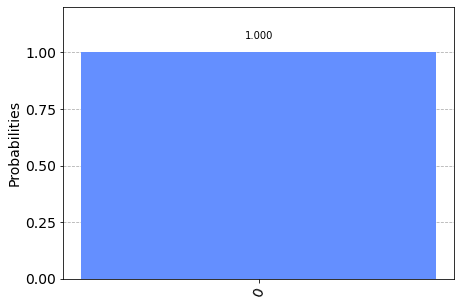

In [86]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts).savefig(f"{results_dir}/inner_product_true.png")

## VMP Oracle

In [64]:
def vmp_marking_oracle(dim_a, barrier=False):
    num_idx_bits = math.ceil(math.log2(dim_a))
    
    # Input data
    matrix_reg = QuantumRegister(dim_a * dim_a, name="a")
    idx_reg = QuantumRegister(num_idx_bits, name="idx")
    x_reg = QuantumRegister(dim_a, name="x")
    y_reg = QuantumRegister(dim_a, name="y")
    z_reg = QuantumRegister(dim_a, name="z")

    # Workspace qubits
    ri_reg = QuantumRegister(dim_a, name="i")
    zi_reg = QuantumRegister(1, name="zi")
    out_reg = QuantumRegister(1, name="out") # also used as marking qubit

    m_i = matrix_row_indexer(dim_a, dim_a).to_gate()
    m_i.name = "A_i Indexer"

    z_i = matrix_row_indexer(dim_a, 1).to_gate()
    z_i.name = "z_i Indexer"

    ip = inner_product(dim_a).to_gate()
    ip.name = "Inner Product"

    qc = QuantumCircuit(matrix_reg, idx_reg, x_reg, y_reg, ri_reg, out_reg, z_reg, zi_reg)

    qc.append(m_i, [*matrix_reg, *idx_reg, *x_reg])
    qc.append(z_i, [*z_reg, *idx_reg, *zi_reg])

    if barrier:
        qc.barrier()

    qc.append(ip, [*x_reg, *y_reg, *ri_reg, *out_reg])

    if barrier:
        qc.barrier()

    qc.cx(zi_reg, out_reg)
    qc.x(out_reg)
    
    if barrier:
        qc.barrier()

    qc.append(ip.inverse(), [*x_reg, *y_reg, *ri_reg, *out_reg])
    
    if barrier:
        qc.barrier()
        
    qc.append(z_i.inverse(), [*z_reg, *idx_reg, *zi_reg])
    qc.append(m_i.inverse(), [*matrix_reg, *idx_reg, *x_reg])
    
    return qc

In [ ]:
a = np.array([[0, 1, 0, 1],
              [1, 1, 1, 0],
              [1, 0, 0, 1],
              [1, 0, 1, 0]])
y = np.array([0, 1, 0, 1])
z = np.array([1, 1, 1, 0])
idx = 1

dim_a = a.shape[0]
num_idx_bits = math.ceil(math.log2(dim_a))

matrix_reg = QuantumRegister(dim_a * dim_a, name="a")
idx_reg = QuantumRegister(num_idx_bits, name="idx")
y_reg = QuantumRegister(dim_a, name="y")
z_reg = QuantumRegister(dim_a, name="z")

# Workspace qubits
x_reg = QuantumRegister(dim_a, name="x") # used to store A[i]
ri_reg = QuantumRegister(dim_a, name="i") # used to store inner product
zi_reg = QuantumRegister(1, name="zi") # used to store z[i]
out_reg = QuantumRegister(1, name="out") # also used as marking qubit
cout_reg = ClassicalRegister(1, name="cout")

qc = QuantumCircuit(matrix_reg, idx_reg, x_reg, y_reg, ri_reg, out_reg, z_reg, zi_reg)

# encode inputs
encode_array(qc, matrix_reg, a)
encode_array(qc, y_reg, y)
encode_array(qc, z_reg, z)

idx_bit_string = format(idx, f'0{num_idx_bits}b')[::-1]
for i, c in enumerate(idx_bit_string):
    if c != '0':
        qc.x(idx_reg[i])

# Put marker qubit in |->
qc.x(out_reg)
qc.h(out_reg)

oracle_qc = vmp_marking_oracle(a.shape[0])
oracle_gate = oracle_qc.to_gate()
oracle_gate.name = "Row Product Oracle"
qc.append(oracle_gate, [*matrix_reg, *idx_reg, *x_reg, *y_reg, *ri_reg, *out_reg, *z_reg, *zi_reg])

# Undo the x and h gates applied to marker qubit
qc.h(out_reg)
qc.x(out_reg)

qc.draw(output="latex")

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
transpiled_qc.decompose().count_ops()

In [ ]:
grover_problem = AmplificationProblem(qc, objective_qubits=[*idx_reg], is_good_state=['00', '11', '10', '01'])
g = Grover()
gqc = g.construct_circuit(grover_problem, 2)

aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(gqc, aer_sim)
transpiled_qc.decompose().count_ops()

In [ ]:
problem = AmplificationProblem(
    qc, 
    state_preparation=gqc, 
    objective_qubits=[*idx_reg], 
    is_good_state=['00', '11', '10', '01']
)
aqc = g.construct_circuit(problem, 1)

aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(aqc, aer_sim)
transpiled_qc.decompose().count_ops()

## Stats

In [50]:
def vmp_circuit_stub(dim_a):
    num_idx_bits = math.ceil(math.log2(dim_a))
    matrix_reg = QuantumRegister(dim_a * dim_a, name="a")
    idx_reg = QuantumRegister(num_idx_bits, name="idx")
    y_reg = QuantumRegister(dim_a, name="y")
    z_reg = QuantumRegister(dim_a, name="z")

    # Workspace qubits
    x_reg = QuantumRegister(dim_a, name="x") # used to store A[i]
    ri_reg = QuantumRegister(dim_a, name="i") # used to store inner product
    zi_reg = QuantumRegister(1, name="zi") # used to store z[i]
    out_reg = QuantumRegister(1, name="out") # also used as marking qubit
    # cout_reg = ClassicalRegister(1, name="cout")

    qc = QuantumCircuit(matrix_reg, idx_reg, x_reg, y_reg, ri_reg, out_reg, z_reg, zi_reg)

    qc.x(out_reg)
    qc.h(out_reg)

    oracle_qc = vmp_marking_oracle(dim_a)
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Row Product Oracle"
    
    qc.append(oracle_gate, [*matrix_reg, *idx_reg, *x_reg, *y_reg, *ri_reg, *out_reg, *z_reg, *zi_reg])
    
    qc.h(out_reg)
    qc.x(out_reg)
    
    is_good_state = [format(i, f'0{int(math.log2(dim_a))}b') for i in range(dim_a)]
    sqrt_n = int(math.sqrt(dim_a))
    sqrt_sqrt_n = int(math.sqrt(sqrt_n))
    
    qc.barrier()
    
    grover_problem = AmplificationProblem(
        qc, 
        objective_qubits=[*idx_reg], 
        is_good_state=is_good_state
    )
    g = Grover()
    gqc = g.construct_circuit(grover_problem, sqrt_n)
    
    gqc.barrier()
    
    problem = AmplificationProblem(
        qc, 
        state_preparation=gqc, 
        objective_qubits=[*idx_reg], 
        is_good_state=is_good_state
    )
    aqc = g.construct_circuit(problem, sqrt_sqrt_n)
    
    return aqc

In [18]:
def aer_transpilation_stats(qc):
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_sim)
    return transpiled_qc.count_ops(), transpiled_qc

In [19]:
def aer_transpile(qc):
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_sim)
    return transpiled_qc

In [ ]:
aer_transpilation_stats(vmp_circuit_stub(32))

In [20]:
import csv
import os
from collections import defaultdict

In [76]:
def _compile_stats(sizes, filename, circuit_lambda):
    stats = []
    fieldnames = set({})
    for sz in sizes:
        transpilation_stats, qc = aer_transpilation_stats(circuit_lambda(sz))
        fieldnames = fieldnames.union(transpilation_stats.keys())
        transpilation_stats["Order"] = sz
        transpilation_stats["Total Gates"] = qc.size()
        transpilation_stats["Circuit Depth"] = qc.depth()
        transpilation_stats["Qubit Count"] = qc.width()
        stats.append(defaultdict(int, transpilation_stats))

    fieldnames = ["Order"] + sorted(fieldnames) + ["Total Gates", "Circuit Depth", "Qubit Count"]

    with open(f"{results_dir}/{filename}.csv", "w") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(stats)

In [ ]:
_compile_stats([2, 4, 8, 16, 24, 32], "vmp_marking_oracle_stats", vmp_marking_oracle)

In [77]:
_compile_stats(
    [2, 4, 8, 16, 24, 32], 
    "vmp_circuit_stats", 
    vmp_circuit_stub
)

In [21]:
import timeit

In [22]:
def _compile_transpile_time_stats(sizes, filename, circuit_lambda):
    times = []
    for sz in sizes:
        qc = circuit_lambda(sz)
        t = timeit.repeat(lambda: aer_transpile(qc), repeat=10, number=1)
        t = np.mean(t)
        print(f"{sz}: {t}s")
        times.append({"Order": sz, "Time (seconds)": t})
    
    fieldnames = ["Order", "Time (seconds)"]
    with open(f"{results_dir}/{filename}.csv", "w") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(times)

In [23]:
_compile_transpile_time_stats([2, 4, 8, 16, 24, 32], "vmp_circuit_transpile_time_stats", vmp_circuit_stub)

2: 0.24860209489997942s
4: 0.8189974269000686s
8: 2.3804883372999486s
16: 27.484900246300004s
24: 65.20581728570009s


KeyboardInterrupt: 

## Figures

In [37]:
# Toffoli and gate
a = QuantumRegister(1, name="a")
b = QuantumRegister(1, name="b")
a_n_b = QuantumRegister(1, name="res")

qc = QuantumCircuit(a, b, a_n_b)
qc.ccx(a, b, a_n_b)

qc.draw(output="latex", scale=0.5).save(f"{results_dir}/toffoli_and.png")

In [42]:
# Matrix indexer circuit A is a 3x3 circuit
qc = matrix_row_indexer(3, 3)
qc.draw(output="latex", scale=0.5).save(f"{results_dir}/indexer_3x3.png")

In [44]:
# Inner product circuit
qc = inner_product(3)
qc.draw(output="latex", scale=0.5).save(f"{results_dir}/inner_product_3x1.png")

In [66]:
# Oracle circuit 4x4
qc = vmp_marking_oracle(4, barrier=True)
qc.draw(output="latex", scale=0.4).save(f"{results_dir}/oracle_circuit_4x4.png")

In [ ]:
# Functionality of matrix indexer

In [ ]:
# Functionality of inner product

In [51]:
# Final circuit (with ampl amplification)
qc = vmp_circuit_stub(4)
# TODO

In [ ]:
# table 1, table 2, table 3 